# Rapid propagation of an input scene through an HLC coronagraph model

crispy can simulate propagation of a full scene through various coronagraph models. Several ingredients are required:
1. an input scene datacube
2. a library of off-axis PSFs for each HLC band that is being considered
3. a stellar PSFs (or a time-resolved sequence)

The following shows how to propagate a scene through a WFIRST HLC model using the three items above. We provide information on how to develop the items above elsewhere in the documentation.

In [1]:
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times',size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.

import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('crispy')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.io import fits
import astropy.units as u
import astropy.constants as c
import os

## Define locations of data files

In [3]:
hlc_psf_path = os.path.normpath('/Users/mrizzo/Science/Haystacks/hlc_haystacks_scene_last')
haystacks_path = '/Users/mrizzo/IFS/crispy/crispy/Inputs/'


## Define some observation parameters

In [4]:
pixscale_as_scene = 0.0208 # arcsec/pixel, from IPAC instrument parameter db
wavelens = np.array([506, 575, 661, 721, 883]) * u.nm # from IPAC instrument parameter db  
bandpass_beg = np.array([480, 546, 628, 703, 860])* u.nm
bandpass_end = np.array([532, 604, 694, 739, 906])* u.nm

os5_wavelen = 550 * u.nm # OS5 HLC simulation center wavelength
N_wav = len(wavelens)

## Load the input cube

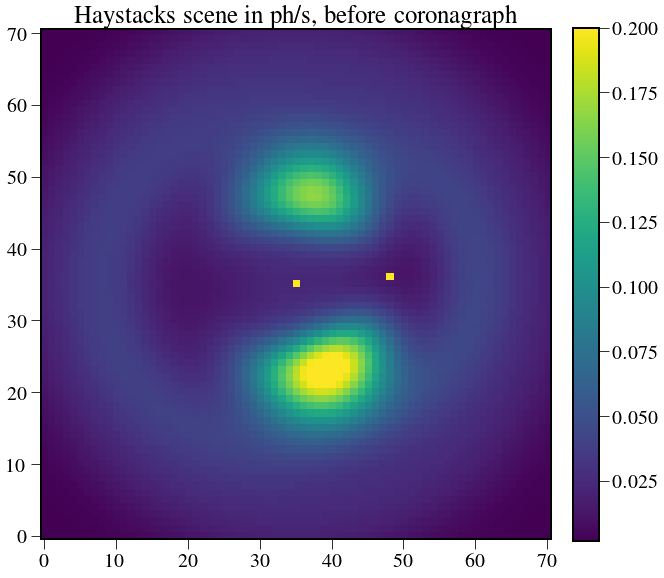

In [5]:
haystacks_fname = os.path.join(haystacks_path,'hay_cube_bandavg_ph.fits.gz')
hay_cube_bandavg_ph = fits.getdata(haystacks_fname)*u.photon/u.s
plt.figure(figsize=(10,10))
plt.imshow(hay_cube_bandavg_ph[1].value, vmax=2e-1)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Haystacks scene in ph/s, before coronagraph',fontsize=25)


In [6]:
log.info('Photon flux from planet before coronagraph: {:}'.format(hay_cube_bandavg_ph[:,36,48]))
log.info('Typically planet fluxes at the detector will be ~a few percent of this')



crispy - INFO - Photon flux from planet before coronagraph: [ 18.13174951  21.66746931   5.99120679   1.89377553   0.34145874] ph / s
crispy - INFO - Typically planet fluxes at the detector will be ~a few percent of this


In [7]:
scene_imw = hay_cube_bandavg_ph.shape[-1]
cx = scene_imw // 2

## Add optical losses & QE

In [8]:
losses = 0.566 * 0.9 # from Bijan's spreadsheet, does not include PSF throughput
qe = np.array([0.92, 0.92, 0.92, 0.75, 0.37])*u.count/u.photon
hay_cube_bandavg_ph *= losses*qe[:,np.newaxis,np.newaxis]
log.info('Applied losses and QE')
# The user may choose to dim the planet at will by multiplying that pixel by a constant
fudge = 0.5
hay_cube_bandavg_ph[:,36,48] *= fudge

contrast = hay_cube_bandavg_ph[:,36,48]/hay_cube_bandavg_ph[1, cx, cx]
log.info('Contrast: {:}'.format(contrast))


crispy - INFO - Applied losses and QE
crispy - INFO - Contrast: [  2.22611779e-08   2.66021427e-08   7.35567849e-09   1.89544141e-09
   1.68601159e-10]


## Load the sequence of stellar PSFs

In [9]:
psf_series_47UMa_p13_fname = os.path.join(hlc_psf_path,
                                          'OS5_adi_3_highres_polx_lowfc_random_47_Uma_roll_p13deg_HLC_sequence.fits')
psf_series_47UMa_m13_fname = os.path.join(hlc_psf_path,
                                          'OS5_adi_3_highres_polx_lowfc_random_47_Uma_roll_m13deg_HLC_sequence.fits')
psf_series_betaUMa_fname = os.path.join(hlc_psf_path,
                                        'OS5_adi_3_highres_polx_lowfc_random_beta_Uma_HLC_sequence.fits')

# this just forms the list of filenames for all the different wavelengths
binned_psf_series_47UMa_p13_fnames = []
binned_psf_series_47UMa_m13_fnames = []
binned_psf_series_betaUMa_fnames = []
for wavelen in wavelens:
    binned_psf_series_47UMa_p13_fnames.append(psf_series_47UMa_p13_fname[:-5] +\
                                              '_sceneF{:d}.fits'.format(int(round(wavelen.value))))
    binned_psf_series_47UMa_m13_fnames.append(psf_series_47UMa_m13_fname[:-5] +\
                                              '_sceneF{:d}.fits'.format(int(round(wavelen.value))))
    binned_psf_series_betaUMa_fnames.append(psf_series_betaUMa_fname[:-5] +\
                                            '_sceneF{:d}.fits'.format(int(round(wavelen.value))))

# load the headers
science_psf_series_header = fits.open(binned_psf_series_47UMa_p13_fnames[0])[0].header
ref_psf_series_header = fits.open(binned_psf_series_betaUMa_fnames[0])[0].header

# pixel scales
pixscale_as_os5 = science_psf_series_header['PIX_AS']
pixscale_ld_os5 = science_psf_series_header['PIX_LD']

log.info('Pixel scale in binned OS5 PSF series: {:.4} arcsec = {:.4f} lam/D at wavelength {:}'.format(
      pixscale_as_os5, pixscale_ld_os5, wavelens[0]))

crispy - INFO - Pixel scale in binned OS5 PSF series: 0.0208 arcsec = 0.4743 lam/D at wavelength 506.0 nm


## Load the offaxis PSF cube

In [10]:
offax_psf_fname = os.path.join(hlc_psf_path,'hlc_offax_psf_quad.fits')
offax_psf_header = fits.open(offax_psf_fname)[0].header
offax_psf = fits.getdata(offax_psf_fname)

## Define the angles of IWA and OWA for the various bands

In [11]:
pixscale_ld_scene = pixscale_ld_os5 * wavelens[0] / wavelens * pixscale_as_scene / pixscale_as_os5

ida_ld_hlc = 1.5
oda_ld_hlc = 9.

ida_as_hlc = np.zeros((N_wav))
oda_as_hlc = np.zeros((N_wav))
mda_as_hlc = np.zeros((N_wav))

for wi in range(N_wav):
    ida_as_hlc[wi] = ida_ld_hlc / pixscale_ld_scene[wi].value * pixscale_as_scene
    oda_as_hlc[wi] = oda_ld_hlc / pixscale_ld_scene[wi].value * pixscale_as_scene
    mda_as_hlc[wi] = np.mean([ida_as_hlc[wi], oda_as_hlc[wi]])

## Convolve the maps

In [12]:
from crispy.tools.cgi import xy_to_psf
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST

### Quick test to determine photon fluence at the planet location

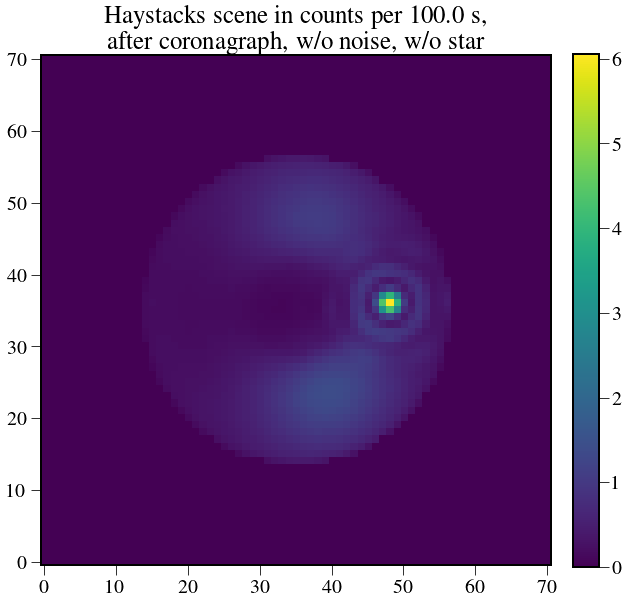

In [13]:
test_scene = np.zeros((scene_imw, scene_imw)) * u.count
# this selects a frame within the cube
wavebin = 1 # I picked the one with the highest flux of all the bands
exptime = 100*u.s
# pseudo-convolution
for x in range(scene_imw):
    for y in range(scene_imw):
        if x != cx and y != cx:
            test_scene += hay_cube_bandavg_ph[wavebin, y, x] * np.nan_to_num(xy_to_psf(x, y, offax_psf[wavebin])) * exptime
plt.figure(figsize=(10,10))
plt.imshow(test_scene)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Haystacks scene in counts per %s, \n after coronagraph, w/o noise, w/o star' % exptime,fontsize=25)

crispy - INFO - Number of counts per pixel in 100 seconds at the planet location: 6.180753709 ct


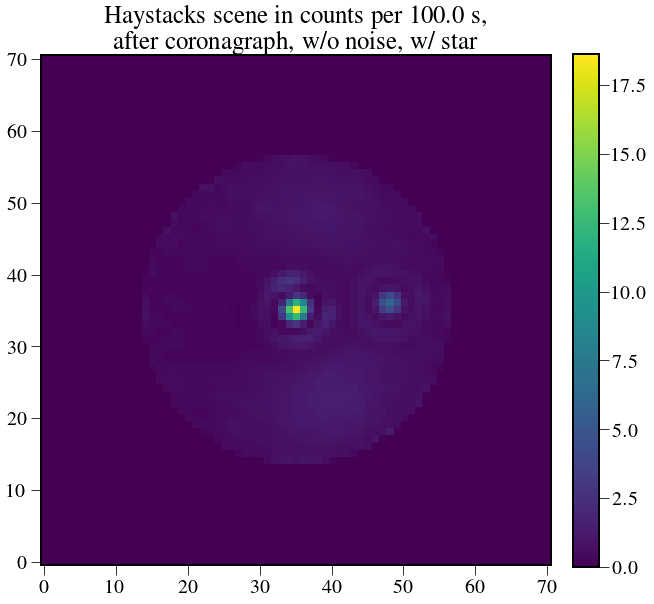

In [14]:
# normalize the stellar PSF
os5sci_totflux = science_psf_series_header['TOTFLUX'] * u.photon
scene_star_totflux = hay_cube_bandavg_ph[wavebin, cx, cx] * exptime
sci_psf_series = fits.getdata(binned_psf_series_47UMa_p13_fnames[wavebin]) * u.photon * \
                   scene_star_totflux / os5sci_totflux
# this automatically includes the QE since we use hay_cube_bandavg_ph as a base

# add to scene
test_scene+= sci_psf_series[0]
plt.figure(figsize=(10,10))
plt.imshow(test_scene)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Haystacks scene in counts per %s, \n after coronagraph, w/o noise, w/ star' % exptime,fontsize=25)
log.info('Number of counts per pixel in 100 seconds at the planet location: {:}'.format(test_scene[36,48]))

### Now do this for real

For photon-counting mode, we want exposures that yield less than 0.1 electrons per frame, otherwise we cut off too many signal electrons. We will thus do individual exposures of ~1.5 seconds. This is overkill for the bands with lower signal as we will accumulate CIC noise too much, so feel free to change that to a different exposure time for each band. 

In [15]:
exptime = 1000. * u.second # total exposure time for an element of the sequence
inttime = 1.5 * u.second # exposure time per frame

# Info for which the sequence frames were computed
os5sci_exptime = science_psf_series_header['EXPTIME'] * u.second
os5sci_totflux = science_psf_series_header['TOTFLUX'] * u.photon
os5ref_exptime = ref_psf_series_header['EXPTIME'] * u.second
os5ref_totflux = ref_psf_series_header['TOTFLUX'] * u.photon
log.info(os5sci_exptime)

crispy - INFO - 1000.0 s


In [16]:
# Number of individual sequence frames to complete an observation 
#(multiplied by exptime that yields the total time spent on source) 
Nint_use = [10, 10, 10, 20, 30]

# we will compute all of the available exposures (so we can play with Nint_use later)
Nsci = science_psf_series_header['NAXIS3']
Nref = ref_psf_series_header['NAXIS3']

# initialize a bunch of arrays
noiseless_sci_scene_nostar = np.zeros((N_wav, scene_imw, scene_imw)) * u.count

noiseless_sci_scene = np.zeros((N_wav, Nsci, scene_imw, scene_imw)) * u.count
noiseless_ref_scene = np.zeros((N_wav, Nref, scene_imw, scene_imw)) * u.count
tavg_noiseless_sci_scene = np.zeros((N_wav, scene_imw, scene_imw)) * u.count/u.s
tavg_noiseless_ref_scene = np.zeros((N_wav, scene_imw, scene_imw)) * u.count/u.s

noisy_sci_scene = np.zeros((N_wav, Nsci, scene_imw, scene_imw)) * u.count
noisy_ref_scene = np.zeros((N_wav, Nref, scene_imw, scene_imw)) * u.count
tavg_noisy_sci_scene = np.zeros((N_wav, scene_imw, scene_imw)) * u.count/u.s
tavg_noisy_ref_scene = np.zeros((N_wav, scene_imw, scene_imw)) * u.count/u.s

tavg_noisy_resid_sci_scene = np.zeros_like(tavg_noisy_sci_scene)
tavg_noisy_resid_sci_scene_contrast = np.zeros(tavg_noisy_sci_scene.shape)

# initialize binary masks to confine region of interest to IWA/OWA
data_mask_nan_ind = []
xs_as = (np.arange(scene_imw) - cx) * pixscale_as_scene
XX_as, YY_as = np.meshgrid(xs_as, xs_as)
RR_as = np.sqrt(XX_as**2 + YY_as**2)
for wi in range(N_wav):
    data_mask_nan_ind.append((RR_as <= ida_as_hlc[wi]) | (RR_as >= oda_as_hlc[wi]))

### Now the big guns

In [17]:
for wi, wavelen in enumerate(wavelens):
    # this is the total amount of photons coming from the star
    scene_star_totflux = hay_cube_bandavg_ph[wi, cx, cx] * exptime
    log.info("F{:} total stellar count rate excluding coronagraph masks: {:.3e} photoelectrons per exposure".format(\
          round(wavelen.value), scene_star_totflux.value))
    
    # select band
    sci_psf_series_fname = binned_psf_series_47UMa_p13_fnames[wi]
    ref_psf_series_fname = binned_psf_series_betaUMa_fnames[wi]

    # scale flux to match star in Haystacks scene (the frames were generated with some arbitrary flux)
    # this already takes QE into account
    sci_psf_series = fits.getdata(sci_psf_series_fname) * u.photon * \
                       scene_star_totflux / os5sci_totflux
    ref_psf_series = fits.getdata(ref_psf_series_fname) * u.photon * \
                       scene_star_totflux / os5ref_totflux
    
    # quick sanity check fro debugging
    assert(int(round(wavelen.value)) == offax_psf_header['WAVE_{:d}'.format(wi+1)])
    
    # this is the key function, that generates an average flux map for the off-axis scene (which is time-invariant)
    # For each pixel, go grab the corresponding off-axis PSF and multiply it by the pixel value
    for x in range(scene_imw):
        for y in range(scene_imw):
            if x != cx and y != cx:
                noiseless_sci_scene_nostar[wi, :, :] += hay_cube_bandavg_ph[wi, y, x] * \
                  np.nan_to_num(xy_to_psf(x, y, offax_psf[wi]))*exptime

    # The on-axis PSF is time-dependent, so we have to read out 
    for tt in range(Nsci):
        # the noiseless electron map is the off-axis PSF + on-axis PSF for this time step
        noiseless_sci_scene[wi, tt, :, :] = sci_psf_series[tt] + noiseless_sci_scene_nostar[wi]
        # mask out area outside WA     
        noiseless_sci_scene[wi, tt, data_mask_nan_ind[wi]]=0.0 
        # simulate EMCCD readout as many times as needed to observe 'exptime' in chunks of 'inttime'
        # this is necessary because of the photon-counting, which doesn't like more than 0.1 counts per single frame
        # by default, QE and losses are set to unity
        noisy_sci_scene[wi, tt, :, :] = readoutWFIRST(noiseless_sci_scene[wi, tt, :, :].value/exptime.value,
                                                        tottime=exptime.value,
                                                        inttime=inttime.value, # only short individual exposures
                                                        PCcorrect=False, # don't correct for photon counting bias
                                                        normalize=False  # don't average frames
                                                     )*u.count      

    # now process the reference PSFs
    for tt in range(Nref):
        noisy_ref_scene[wi, tt, data_mask_nan_ind[wi]] = 0.0
        noisy_ref_scene[wi, tt, :, :] = readoutWFIRST(ref_psf_series[tt].value/exptime.value,
                                                      tottime=exptime.value,
                                                      inttime=1., # only short individual exposures
                                                      PCcorrect=False, # don't correct for photon counting bias
                                                      normalize=False  # don't average frames
                                                     )*u.count

    # now we can make some averages, using the Nint_use values
    tavg_noiseless_sci_scene[wi] = np.mean(noiseless_sci_scene[wi, :Nint_use[wi]], axis=0)/exptime

    # this is a slight adjustment coming from photon counting mode
    EMGain = 2500. # EM amplifier gain
    RN = 100 # read noise in counts rms
    threshold = 6 # photon counting threshold
    tavg_noisy_sci_scene[wi] = np.mean(noisy_sci_scene[wi, :Nint_use[wi]], axis=0)*np.exp(100.*threshold/2500.)/exptime
    
    tavg_noiseless_ref_scene[wi] = np.mean(ref_psf_series[:Nint_use[wi]], axis=0)/exptime
    tavg_noisy_ref_scene[wi] = np.mean(noisy_ref_scene[wi,:Nint_use[wi]], axis=0)*np.exp(100.*threshold/2500.)/exptime
    
    tavg_noisy_sci_scene[wi, data_mask_nan_ind[wi]] = np.nan
    tavg_noisy_ref_scene[wi, data_mask_nan_ind[wi]] = np.nan
    
    # elementary PSF subtraction
    tavg_noisy_resid_sci_scene[wi] = tavg_noisy_sci_scene[wi] - tavg_noisy_ref_scene[wi]
    tavg_noisy_resid_sci_scene_contrast[wi] = \
    tavg_noisy_resid_sci_scene[wi] / (np.nanmax(offax_psf[wi]) * scene_star_totflux) 

crispy - INFO - F506.0 total stellar count rate excluding coronagraph masks: 1.587e+11 photoelectrons per exposure
crispy - INFO - F575.0 total stellar count rate excluding coronagraph masks: 1.909e+11 photoelectrons per exposure
crispy - INFO - F661.0 total stellar count rate excluding coronagraph masks: 2.113e+11 photoelectrons per exposure
crispy - INFO - F721.0 total stellar count rate excluding coronagraph masks: 7.336e+10 photoelectrons per exposure
crispy - INFO - F883.0 total stellar count rate excluding coronagraph masks: 1.912e+10 photoelectrons per exposure


## Now let's explore what we have done...

In [18]:
# hdu = fits.HDUList([fits.PrimaryHDU(tavg_noisy_sci_scene.value)])
# hdu.writeto('tavg_sciscene.fits',overwrite=True)
# hdu = fits.HDUList([fits.PrimaryHDU(tavg_noisy_ref_scene.value)])
# hdu.writeto('tavg_refscene.fits',overwrite=True)
# hdu = fits.HDUList([fits.PrimaryHDU(tavg_noisy_resid_sci_scene.value)])
# hdu.writeto('tavg_resid.fits',overwrite=True)

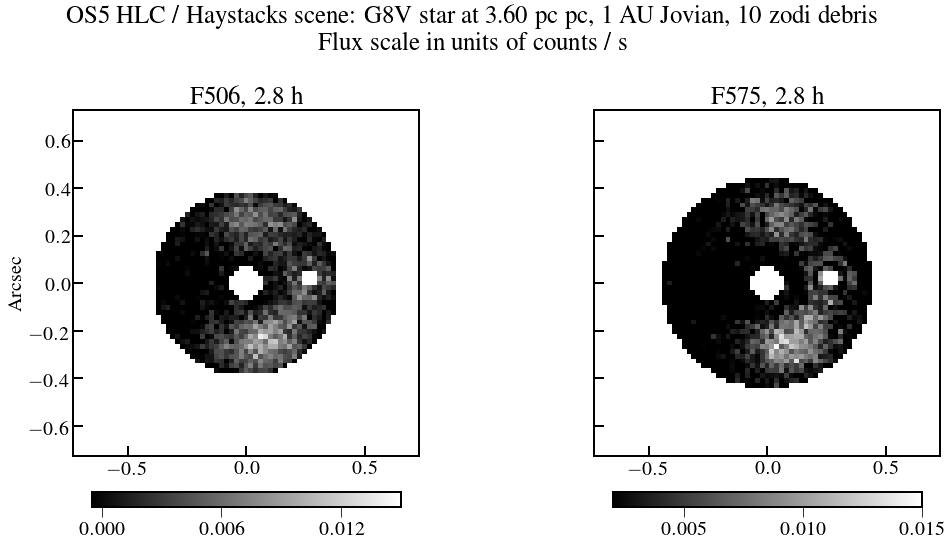

In [19]:
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)
from astropy.visualization import simple_norm

dist_scene = 3.6*u.pc

plt.figure(figsize=(16,8))
plt.suptitle('OS5 HLC / Haystacks scene: G8V star at {:.2f} pc, 1 AU Jovian, 10 zodi debris\nFlux scale in units of counts / s'.format(dist_scene))
plt.subplots_adjust(left=0.08, right=0.98, wspace = 0.01, bottom=0.02, top=0.80)
plt.subplot(121)
plt.imshow(tavg_noisy_resid_sci_scene[0],
           extent = (xs_as[0], xs_as[-1], xs_as[0], xs_as[-1]),
           vmin=-0.5e-3, vmax=1.5e-2,cmap='gray')
plt.tick_params(width=2, length=10, direction='in')
plt.ylabel('Arcsec')
plt.title('F506, {:.1f}'.format(Nint_use[0]*exptime.to(u.hour)),fontsize=25)
cb = plt.colorbar(shrink=0.6, orientation='horizontal', pad=0.08)
cb.locator = matplotlib.ticker.MaxNLocator(nbins=3)
cb.update_ticks()

plt.subplot(122)
plt.imshow(tavg_noisy_resid_sci_scene[1],
           extent = (xs_as[0], xs_as[-1], xs_as[0], xs_as[-1]),
           vmin=2e-3, vmax=1.5e-2,cmap='gray')
plt.tick_params(labelleft='off', width=2, length=10, direction='in')
#plt.axes('off', which='y')
#plt.colorbar()
#plt.xlabel('Arcsec')
plt.title('F575, {:.1f}'.format(Nint_use[1]*exptime.to(u.hour)),fontsize=25)
cb = plt.colorbar(shrink=0.6, orientation='horizontal', pad=0.08)
cb.locator = matplotlib.ticker.MaxNLocator(nbins=3)
cb.update_ticks()



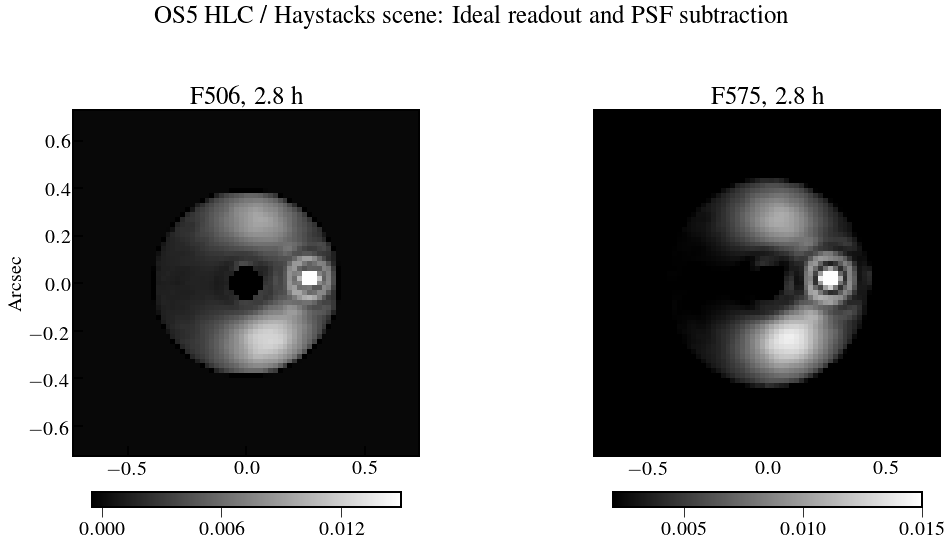

In [20]:
plt.figure(figsize=(16,8))
plt.suptitle('OS5 HLC / Haystacks scene: Ideal readout and PSF subtraction')
plt.subplots_adjust(left=0.08, right=0.98, wspace = 0.01, bottom=0.02, top=0.80)
plt.subplot(121)
plt.imshow(tavg_noiseless_sci_scene[0]-tavg_noiseless_ref_scene[0],
           extent = (xs_as[0], xs_as[-1], xs_as[0], xs_as[-1]),
           vmin=-0.5e-3, vmax=1.5e-2,cmap='gray')
plt.tick_params(width=2, length=10, direction='in')
plt.ylabel('Arcsec')
plt.title('F506, {:.1f}'.format(Nint_use[0]*exptime.to(u.hour)),fontsize=25)
cb = plt.colorbar(shrink=0.6, orientation='horizontal', pad=0.08)
cb.locator = matplotlib.ticker.MaxNLocator(nbins=3)
cb.update_ticks()

plt.subplot(122)
plt.imshow(tavg_noiseless_sci_scene[1]-tavg_noiseless_ref_scene[1],
           extent = (xs_as[0], xs_as[-1], xs_as[0], xs_as[-1]),
           vmin=2e-3, vmax=1.5e-2,cmap='gray')
plt.tick_params(labelleft='off', width=2, length=10, direction='in')
#plt.axes('off', which='y')
#plt.colorbar()
#plt.xlabel('Arcsec')
plt.title('F575, {:.1f}'.format(Nint_use[1]*exptime.to(u.hour)),fontsize=25)
cb = plt.colorbar(shrink=0.6, orientation='horizontal', pad=0.08)
cb.locator = matplotlib.ticker.MaxNLocator(nbins=3)
cb.update_ticks()


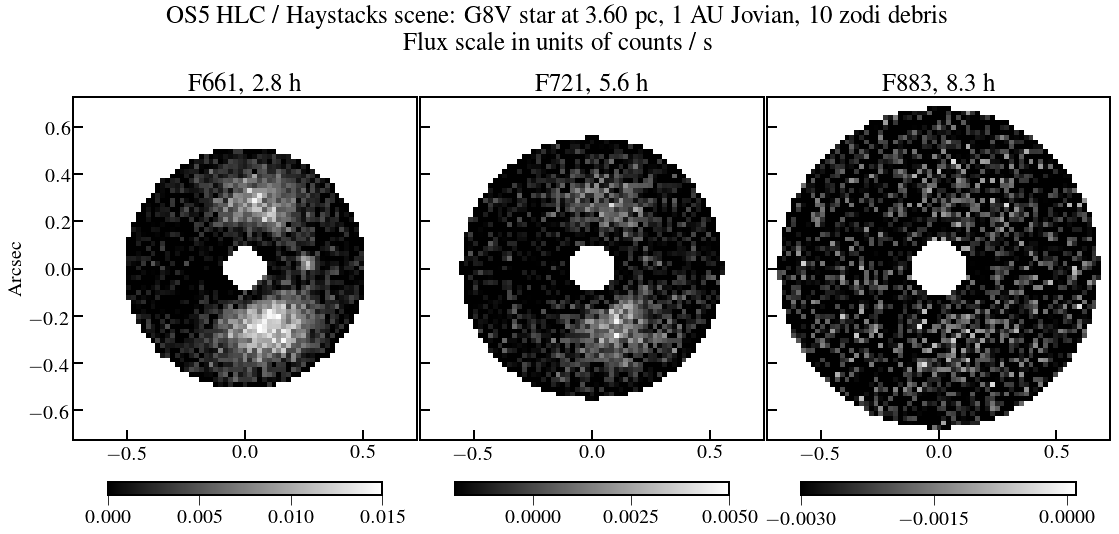

In [21]:
plt.figure(figsize=(16,8))
plt.suptitle('OS5 HLC / Haystacks scene: G8V star at {:.2f}, 1 AU Jovian, 10 zodi debris\nFlux scale in units of counts / s'.format(dist_scene))
plt.subplots_adjust(left=0.08, right=0.98, wspace = 0.01, bottom=0.02, top=0.92)
plt.subplot(131)
plt.imshow(tavg_noisy_resid_sci_scene[2],
           extent = (xs_as[0], xs_as[-1], xs_as[0], xs_as[-1]),
           vmin=0e-2, vmax=1.5e-2,cmap='gray')
plt.tick_params(width=2, length=10, direction='in')
plt.ylabel('Arcsec')
plt.title('F661, {:.1f}'.format(Nint_use[2]*exptime.to(u.hour)),fontsize=25)
cb = plt.colorbar(shrink=0.8, orientation='horizontal', pad=0.08)
cb.locator = matplotlib.ticker.MaxNLocator(nbins=3)
cb.update_ticks()

plt.subplot(132)
plt.imshow(tavg_noisy_resid_sci_scene[3],
           extent = (xs_as[0], xs_as[-1], xs_as[0], xs_as[-1]),
           vmin=-2e-3, vmax=5e-3,cmap='gray')
plt.tick_params(labelleft='off', width=2, length=10, direction='in')
#plt.axes('off', which='y')
#plt.colorbar()
#plt.xlabel('Arcsec')
plt.title('F721, {:.1f}'.format(Nint_use[3]*exptime.to(u.hour)),fontsize=25)
cb = plt.colorbar(shrink=0.8, orientation='horizontal', pad=0.08)
cb.locator = matplotlib.ticker.MaxNLocator(nbins=3)
cb.update_ticks()


plt.subplot(133)
plt.imshow(tavg_noisy_resid_sci_scene[4],
           extent = (xs_as[0], xs_as[-1], xs_as[0], xs_as[-1]),           
           vmin=-3e-3,vmax = 1e-4, cmap='gray')
plt.tick_params(labelleft='off', width=2, length=10, direction='in')
#plt.colorbar()e
#plt.xlabel('Arcsec')
plt.title('F883, {:.1f}'.format(Nint_use[4]*exptime.to(u.hour)),fontsize=25)
cb = plt.colorbar(shrink=0.8, orientation='horizontal', pad=0.08)
cb.locator = matplotlib.ticker.MaxNLocator(nbins=3)
cb.update_ticks()

# plt.savefig('os5_hlc_haystack_scene.png', dpi=100)

### Plot Haystacks counts before convolution with coronagraph

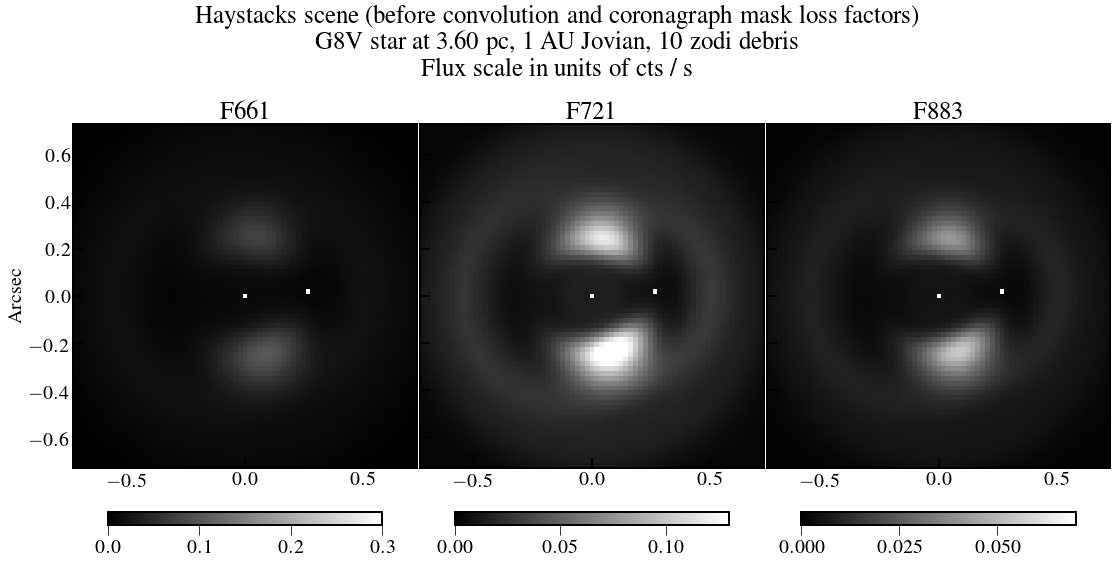

In [22]:
plt.figure(figsize=(16,8.5))
# hdu = fits.HDUList([fits.PrimaryHDU(hay_cube_bandavg_ph.value)])
# hdu.writeto('haystacks_ctspersec.fits',overwrite=True)

plt.suptitle('Haystacks scene (before convolution and coronagraph mask loss factors)\nG8V star at {:.2f}, 1 AU Jovian, 10 zodi debris\nFlux scale in units of cts / s'.format(dist_scene))
plt.subplots_adjust(left=0.08, right=0.98, wspace = 0.01, bottom=0.02, top=0.92)
plt.subplot(131)
plt.imshow(hay_cube_bandavg_ph[1],
           extent = (xs_as[0], xs_as[-1], xs_as[0], xs_as[-1]),
           vmin=0, vmax = 3e-1, cmap='gray')
plt.tick_params(width=2, length=10, direction='in')
plt.ylabel('Arcsec')
plt.title('F661',fontsize=25)
cb = plt.colorbar(shrink=0.8, orientation='horizontal', pad=0.08)
cb.locator = matplotlib.ticker.MaxNLocator(nbins=3)
cb.update_ticks()

plt.subplot(132)
plt.imshow(hay_cube_bandavg_ph[2],
           extent = (xs_as[0], xs_as[-1], xs_as[0], xs_as[-1]),
           vmin=0, vmax = 1.3e-1, cmap='gray')
plt.tick_params(labelleft='off', width=2, length=10, direction='in')
#plt.axes('off', which='y')
#plt.colorbar()
#plt.xlabel('Arcsec')
plt.title('F721',fontsize=25)
cb = plt.colorbar(shrink=0.8, orientation='horizontal', pad=0.08)
cb.locator = matplotlib.ticker.MaxNLocator(nbins=3)
cb.update_ticks()


plt.subplot(133)
plt.imshow(hay_cube_bandavg_ph[3],
           extent = (xs_as[0], xs_as[-1], xs_as[0], xs_as[-1]),           
           vmin=0, vmax = 7e-2, cmap='gray')
plt.tick_params(labelleft='off', width=2, length=10, direction='in')
#plt.colorbar()
#plt.xlabel('Arcsec')
plt.title('F883',fontsize=25)
cb = plt.colorbar(shrink=0.8, orientation='horizontal', pad=0.08)
cb.locator = matplotlib.ticker.MaxNLocator(nbins=3)
cb.update_ticks()

#plt.savefig('os5_hlc_haystack_scene_before_conv.png', dpi=100)